<img src="media/Cryo+ESA_Logo_plain-50gray.svg" alt="CCI Cryosphere banner" width="1000"/>

# Exercise plotting grounding line locations and Velocities for the the Pine Island  and Thwaites glacier

The velocity and grounding line CCI datasets from the open data portal, allow a closer look at some of the Antarctic glaciers. Two large glaciers, which are undergoing a rapid change at the moment are the Thwaites glacier and Pine Island glacier. I this exercise you'll plot the grounding lines and glacier velocities.

## Preparations
If you haven't done so please follow the [Cate tutorial](futurelearn.com/tbd) to get started using the exercises.


In [1]:
# To get things started we need to initialize a few things
#Load some python modules to make them accessible to the notebook
from cate.core.ds import DATA_STORE_REGISTRY
import cate.ops as ops
from cate.util.monitor import ConsoleMonitor
import os
#temporary hack to work around (https://stackoverflow.com/questions/56154176/runtimeerror-asyncio-run-cannot-be-called-from-a-running-event-loop)
import nest_asyncio
nest_asyncio.apply()
# end temporary hack

monitor=ConsoleMonitor()

In [2]:
#initialize the local data store
data_store = DATA_STORE_REGISTRY.get_data_store('local')

In [13]:
#setup some trings to name the datasources and files (Grounding lines)
dsid="local.AIS_CCI_GLL_Ferrigno_PineIS_Thwaites_Smith_Pope_Kohler"
basen="20170428_090554_AIS_CCI_GLL_Ferrigno_PineIS_Thwaites_Smith_Pope_Kohler"
shpfile=os.path.join(dsid,basen+".shp")


#setup some trings to name the datasources and files (velocity geotiffs)
fileN="ais_cci_iv_PIG_S1avg_v20160125_v1_vv.tif"
vdsid="local.AIS_CCI_IV_PIG_S1"
tiffFile=os.path.join(vdsid,fileN)


In [ ]:
#Download the Pine island glacier grounding line shapefiles and make them available through cate
import os
import requests
import urllib.request
from datetime import datetime
from cate.core.ds import DataAccessError

# Download shapefiles of the grounding line locations
rooturl="https://data.cci.ceda.ac.uk/thredds/fileServer/esacci/ice_sheets_antarctica/data/grounding_line_locations/Ferrigno_PineIS_Thwaites_Smith_Pope_Kohler/v2.0_cci_subset/"
urls=[rooturl+"00README_catalogue_and_licence.txt"]
basen="20170428_090554_AIS_CCI_GLL_Ferrigno_PineIS_Thwaites_Smith_Pope_Kohler"
for suf in [".shp",".dbf",".shx",".prj"]:
    urls.append(rooturl+basen+suf)


#directory to download the data to. For the datasource naming to be consistent but make sure it's located in the _store_dir directory of your local datastore and the subdirectory start with 'local.'' 
downloadDir=os.path.join(data_store._store_dir,dsid)

os.makedirs(downloadDir, exist_ok=True)
for url in urls:
    r=requests.get(url)
    fileOut=os.path.join(downloadDir,os.path.basename(url))
    if os.path.exists(fileOut):
        print("Already downloaded, skipping %s"%fileOut)
        continue
    print("Downloading %s"%fileOut)
    with open(fileOut,'wb') as fid:
        fid.write(r.content)


#create a new datasource and add the *shp file
try:
    ds=data_store.create_data_source(dsid,title=dsid)
    ds.add_dataset(shpfile,(datetime(1995,10,19),datetime(2017,1,14)))
    ds.set_completed(True)
except DataAccessError:
    #OK since it already registered
    pass

#also download the geotiff of averaged absolute velocities of the Pine Island and Thwaites glacier
vrooturl="ftp://anon-ftp.ceda.ac.uk/neodc/esacci/ice_sheets_antarctica/data/ice_velocity/pine_island_glacier/v1.0/ais_cci_iv_PIG_S1t065_20141010_20160121_v160427/"
vdownloadDir=os.path.join(data_store._store_dir,vdsid)
os.makedirs(vdownloadDir, exist_ok=True)

with urllib.request.urlopen(vrooturl+fileN) as r:
    fileOut=os.path.join(vdownloadDir,fileN)
    if os.path.exists(fileOut):
        print("Already downloaded, skipping %s"%fileOut)
    else:
        with open(fileOut,"wb") as fid:
            print("Downloading %s"%fileOut)
            fid.write(r.read())

        
try:
    vds=data_store.create_data_source(vdsid,title=vdsid)
    vds.add_dataset(tiffFile,(datetime(2014,10,9),datetime(2016,1,21)))
    vds.set_completed(True)
except DataAccessError:
    #OK dataset is already registered
    pass

#make sure the change is reflected in the local datastore by invalidating (reloading) the cache
data_store.invalidate()

In [ ]:
#Until cate supports reading shapefiles directly through the datastore read the shapefiles from a file
from cate.ops import read_geo_data_frame
import xarray as xr

PinesGLL=read_geo_data_frame(os.path.join(data_store._store_dir,shpfile))

#also read the tiff file with absolute velocities
velo=xr.open_rasterio(os.path.join(data_store._store_dir,tiffFile))
#mask nodatavalues (so they won't be plotted)
velo=velo.where(velo != velo.nodatavals[0])


<ipython-input-34-e072a80d8334>:20: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.text(-106.749997,-75.499998,"Thwaites glacier",transform=ccrs.PlateCarree(),FontSize=16)
<ipython-input-34-e072a80d8334>:21: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.text(-99,-75.4,"Pine Island glacier",transform=ccrs.PlateCarree(),FontSize=16)


Text(0.5, 1.0, 'Pine Island and Thwaites averaged glacier velocities [m/day] and a selection of grounding lines')

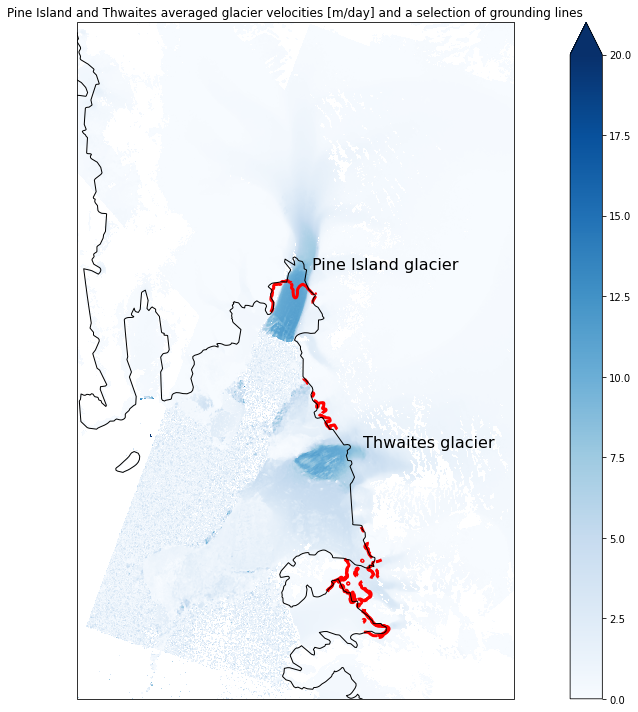

In [34]:
# create a plot of the velocities and grounding lines of Pine Island and Thwaites glacier
%matplotlib inline
import cartopy.crs as ccrs
import matplotlib.pyplot as mpl
import rasterio.plot

mpl.figure(figsize=(16,10))
#note the projection below corresponds to the EPSG 3031 which is the samge projection as used by the ice velocity Geotiff
crs=ccrs.SouthPolarStereo(0,true_scale_latitude=-71)

ax = mpl.subplot(projection=crs)
velo[0,:,:].plot.imshow(ax=ax,vmin=0,vmax=20,cmap="Blues")

#plot the grounding lines
PinesGLLReproject=PinesGLL.to_crs(crs.proj4_init)
ax.add_geometries(PinesGLLReproject.geometry,crs=crs,edgeColor='red',faceColor='none',lineWidth=3)
ax.coastlines(resolution='10m')

#add some labels to recognize the glaciers
ax.text(-106.749997,-75.499998,"Thwaites glacier",transform=ccrs.PlateCarree(),FontSize=16)
ax.text(-99,-75.4,"Pine Island glacier",transform=ccrs.PlateCarree(),FontSize=16)

ax.set_title("Pine Island and Thwaites averaged glacier velocities [m/day] and a selection of grounding lines")


# Questions
1. Can you spot the glacier front of the Pine Island glacier? Why is there such big difference between the location of the glacier front and the grounding line?
2. The grounding line for the Thwaites glacier is not shown, were would you expect to find it?
3. Try plotting a scalebar on top of the plot to get an idea for the dimensions of the glaciers 